In [15]:
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [17]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [18]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define the main directory containing subdirectories for each category
main_dir = "/content/drive/MyDrive/PlantVillage"

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256,256)),  # Resize images to a consistent size
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Create an ImageFolder dataset
dataset = ImageFolder(root=main_dir, transform=transform)

# Define the sizes for train, validation, and test sets (e.g., 80-10-10 split)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader objects for train, validation, and test sets
batch_size = 32 # Adjust the batch size based on your system's memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# You can now use train_loader, val_loader, and test_loader for training and evaluation.


In [19]:
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Visualize some of the images from our dataset

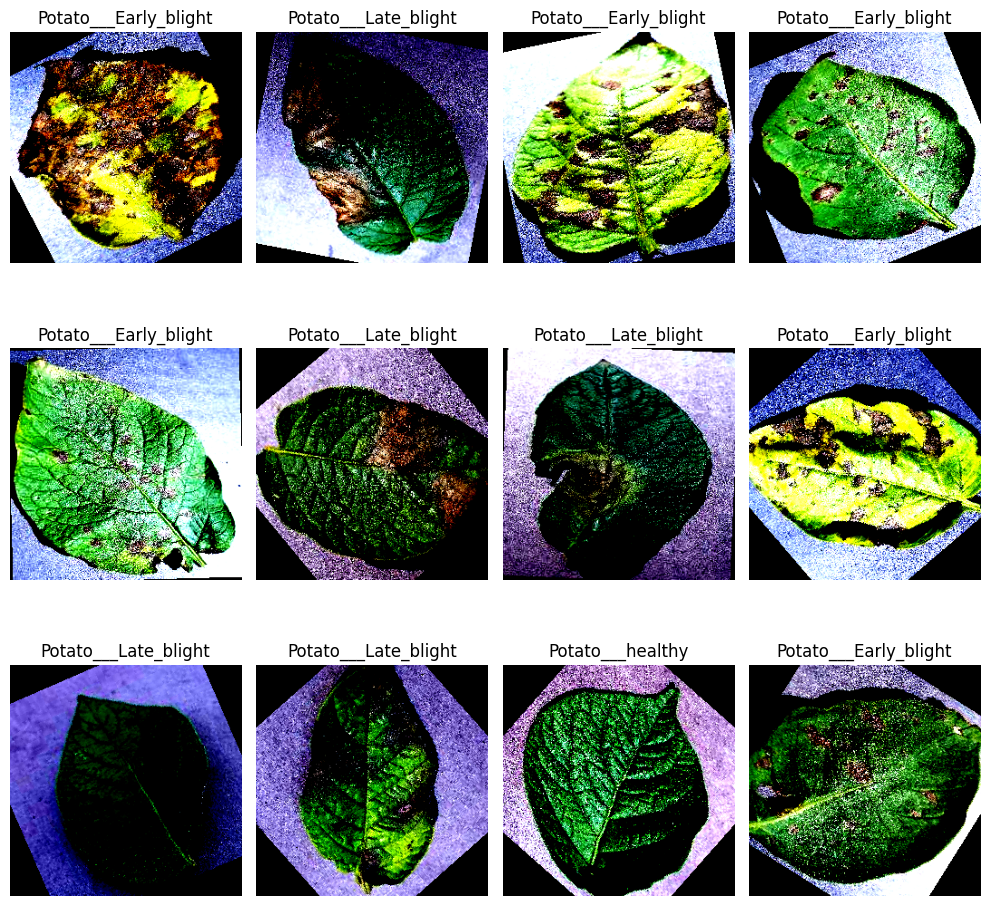

In [20]:
# plt.figure(figsize=(10, 10))
# for image_batch, labels_batch in dataset:
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         plt.imshow(train_loader[i][0].numpy().astype("uint8"))
#         plt.title(class_names[train_loader[i][1]])
#         plt.axis("off")

import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Assuming you have already defined your DataLoader as train_loader

# Define a function to display images
def imshow(img, title):
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a batch of data from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)


# Display 12 images
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    imshow(images[i], title=class_names[labels[i]])

plt.tight_layout()
plt.show()

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [21]:
len(dataset)

2152

Building the Model
Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

Applying Data Augmentation to Train Dataset

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [23]:
len(train_loader)

54

In [24]:
len(test_loader)

7

Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [25]:
from torchvision import transforms as T
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import torch
from tqdm.notebook import tqdm as tqdm

In [26]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        flat_features = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        # print(x.shape)
        x = self.classifier(x)
        return x

    def init_optimizer(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Assuming n_classes is the number of classes in your classification problem
n_classes = 3
input_shape = (3, 256,256)  # Replace <height> and <width> with your image dimensions


# Create an instance of the CustomCNN model
model = CustomCNN(num_classes=n_classes)

def evaluate(model, testloader):
    # model.eval()
    with torch.no_grad():
        val_loss, val_acc = 0.0, 0.0
        for val_batch in testloader:
            imgs, targets = val_batch
            #print(imgs.shape, targets.shape)
            #print(targets)
            imgs, targets = imgs.to(device), targets.to(device).long()
            val_outputs = model(imgs)
            val_loss += torch.nn.functional.cross_entropy(val_outputs, targets).item()
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc += torch.sum(val_preds == targets)
    val_acc = float(float(val_acc)/float(len(testloader)*32))
    return val_acc,val_loss

def save_model(model):
    if not os.path.isdir('saved_models'):
        os.mkdir('saved_models')

    torch.save(model.state_dict(), os.path.join('saved_models', 'model.pt'))
    print("Model successfully saved.")

def load_model(model):
    model.load_state_dict(torch.load(os.path.join('saved_models', 'model.pt')))
    return model

Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [27]:

num_epochs = 50

model =CustomCNN(3).to(device)
model.train()
optimizer = model.init_optimizer()

train_loss_model=[]
train_acc_model=[]
Val_acc_model=[]
Val_loss_model=[]

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(train_loader)) as pbar:
        for idx, batch in enumerate(train_loader):

            images, labels = batch
            images, labels = images.to(device), labels.to(device).long()

            preds = model(images)
            loss = torch.nn.functional.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(preds, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(idx+1)))))
            pbar.update(1)

        train_loss_model.append(train_loss)
        train_acc_model.append(round(float(train_acc.item()/(32.0*(idx+1))),4))
        #print("epoch completed")
        Val_acc,val_loss = evaluate(model, val_loader)
        Val_acc_model.append(round(Val_acc,4))
        Val_loss_model.append(round(val_loss,4))

        # #print("epoch completed")
        # val_acc,val_loss = evaluate(model, test_loader)

        print("train_acc:", round(float(float(train_acc)/float(len(train_loader)*32)), 4), " val_acc:", round(Val_acc, 4))



Epoch:  1 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.6991  val_acc: 0.7946

Epoch:  2 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.8495  val_acc: 0.7455

Epoch:  3 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.8744  val_acc: 0.9018

Epoch:  4 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9196  val_acc: 0.8929

Epoch:  5 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9398  val_acc: 0.9107

Epoch:  6 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.952  val_acc: 0.9241

Epoch:  7 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9641  val_acc: 0.8973

Epoch:  8 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9705  val_acc: 0.9286

Epoch:  9 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9641  val_acc: 0.933

Epoch:  10 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9815  val_acc: 0.875

Epoch:  11 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.8987  val_acc: 0.8973

Epoch:  12 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9688  val_acc: 0.933

Epoch:  13 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9751  val_acc: 0.9375

Epoch:  14 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9601  val_acc: 0.9375

Epoch:  15 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9757  val_acc: 0.9375

Epoch:  16 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9855  val_acc: 0.9375

Epoch:  17 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9722  val_acc: 0.942

Epoch:  18 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9855  val_acc: 0.933

Epoch:  19 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9809  val_acc: 0.942

Epoch:  20 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9913  val_acc: 0.9464

Epoch:  21 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9873  val_acc: 0.942

Epoch:  22 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9693  val_acc: 0.9375

Epoch:  23 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9832  val_acc: 0.9375

Epoch:  24 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9878  val_acc: 0.9375

Epoch:  25 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9884  val_acc: 0.9509

Epoch:  26 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9902  val_acc: 0.942

Epoch:  27 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9919  val_acc: 0.942

Epoch:  28 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9907  val_acc: 0.9464

Epoch:  29 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9907  val_acc: 0.9464

Epoch:  30 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9873  val_acc: 0.942

Epoch:  31 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.989  val_acc: 0.933

Epoch:  32 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9751  val_acc: 0.9196

Epoch:  33 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9861  val_acc: 0.9375

Epoch:  34 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9884  val_acc: 0.9375

Epoch:  35 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9867  val_acc: 0.9375

Epoch:  36 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9942  val_acc: 0.9509

Epoch:  37 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9942  val_acc: 0.933

Epoch:  38 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9832  val_acc: 0.9018

Epoch:  39 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9815  val_acc: 0.9464

Epoch:  40 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9936  val_acc: 0.9464

Epoch:  41 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9942  val_acc: 0.9375

Epoch:  42 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9959  val_acc: 0.9375

Epoch:  43 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9948  val_acc: 0.9464

Epoch:  44 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9948  val_acc: 0.9509

Epoch:  45 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9925  val_acc: 0.9464

Epoch:  46 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9936  val_acc: 0.9554

Epoch:  47 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9902  val_acc: 0.9375

Epoch:  48 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9919  val_acc: 0.942

Epoch:  49 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9948  val_acc: 0.9554

Epoch:  50 / 50


  0%|          | 0/54 [00:00<?, ?it/s]

train_acc: 0.9954  val_acc: 0.9554


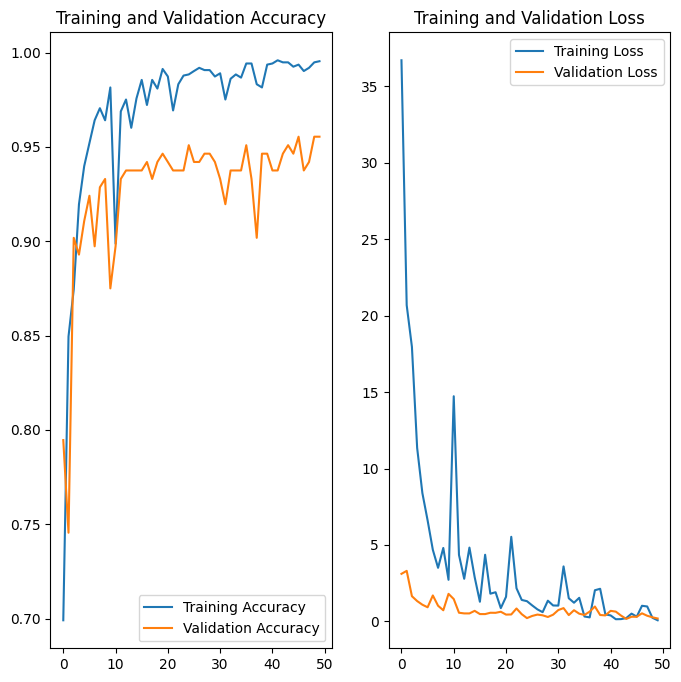

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
EPOCHS=50
plt.plot(range(EPOCHS), train_acc_model, label='Training Accuracy')
plt.plot(range(EPOCHS), Val_acc_model, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), train_loss_model, label='Training Loss')
plt.plot(range(EPOCHS), Val_loss_model, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
import torch
import numpy as np

def predict(model, img):
    # Convert the image to a PyTorch tensor
    img_tensor = torch.from_numpy(img)
    img_tensor=img_tensor.to(device)

    # torch.argmax(preds, dim=1)

    # Perform inference (forward pass) with the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(img_tensor)

    # Get the predicted class and confidence
    # _, predicted_class = output.max(1)
    # confidence = round(100 * torch.softmax(output, dim=1)[0, predicted_class], 2)
    output_label=torch.argmax(output, dim=1)

    return output_label


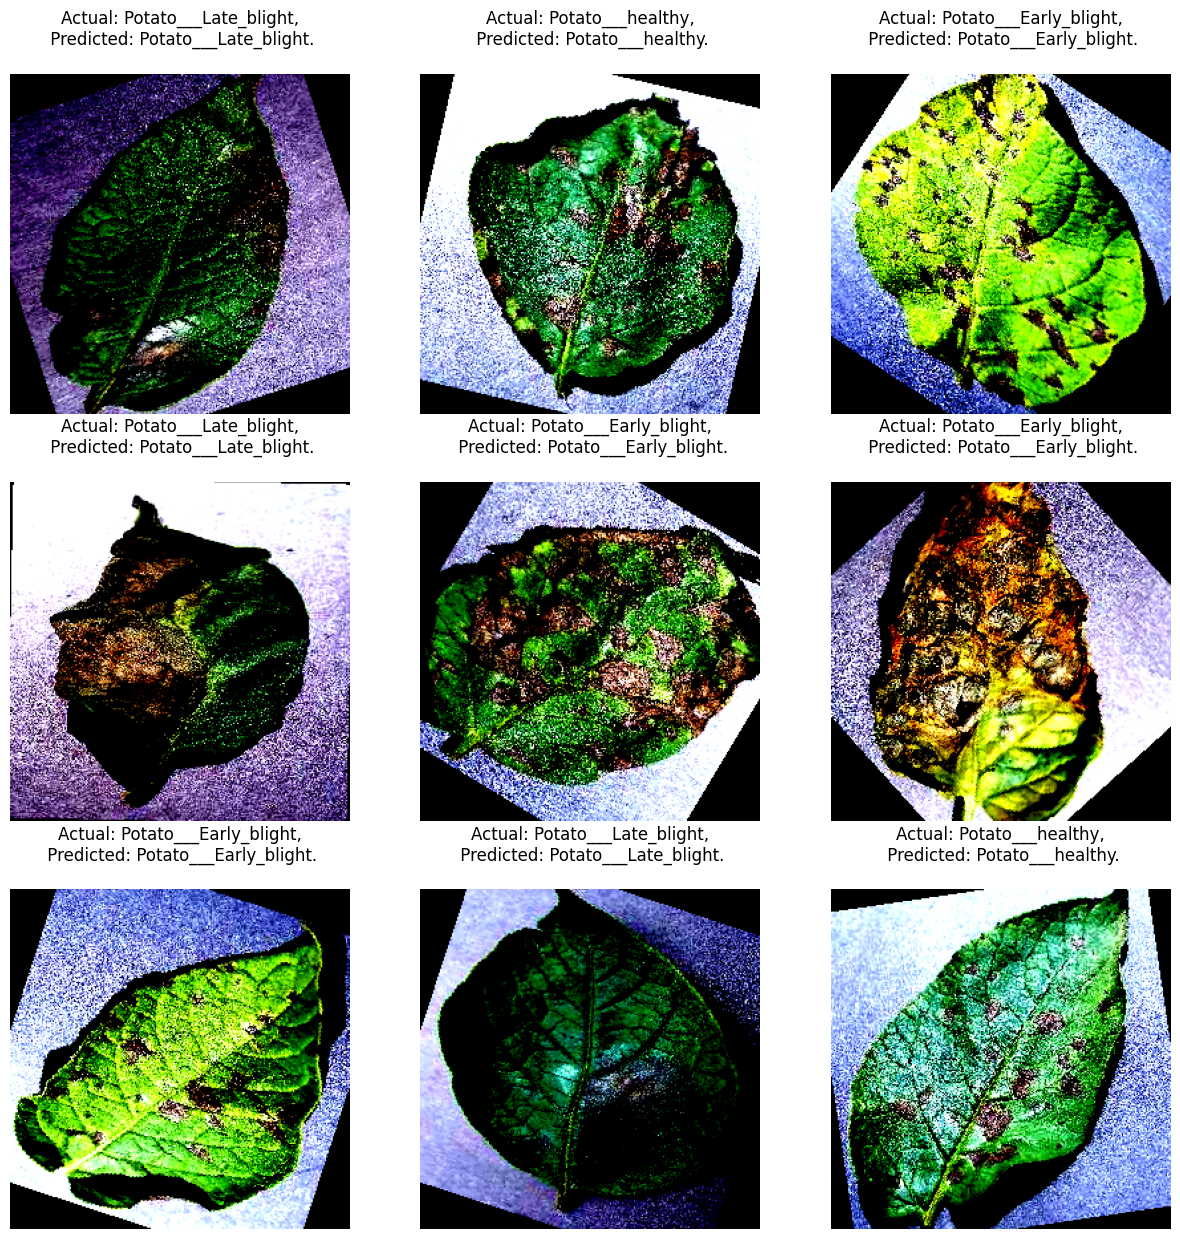

In [51]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    model.eval()  # Set the model to evaluation mode

    for images, labels in dataloader:
        images.to(device), labels.to(device).long()
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            img = images[i]
            plt.imshow(img.numpy().transpose((1, 2, 0)))

            # Convert the PyTorch tensor to a NumPy array before prediction
            img_numpy = images[i]
            img_numpy=img_numpy.to(device)

            # Perform prediction using the PyTorch model
            output_label = predict(model, (img.numpy().transpose((1, 2, 0))).reshape(-1, img.shape[0] , img.shape[1] , img.shape[2]))
            actual_class = output_label

            plt.title(f"Actual: {class_names[actual_class]},\n Predicted: {class_names[output_label] }.\n ")
            plt.axis("off")

            if i == num_images - 1:
                break
        break  # Display only one batch of data

# Assuming you have a PyTorch DataLoader called 'test_dataloader' and 'class_names' defined
visualize_predictions(model, test_loader, class_names)
plt.show()

